In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Todd Ideas,290.411196,19.360746,15
Powershell,541.080514,54.108051,10
Terraform,723.873493,28.954940,25
Azure Functions,780.275335,70.934121,11
SharePoint,1032.330066,86.027505,12
Email Auth and Security,1240.999018,95.461463,13
FSLogix,1277.813491,53.242229,24
Azure Functions + Visual Studio,1290.659107,92.189936,14
Audit Report Tracker (Sharepoint List),1313.815705,82.113482,16
IW Migration,1473.297834,105.235560,14


# Histogram

40784.90


<Axes: >

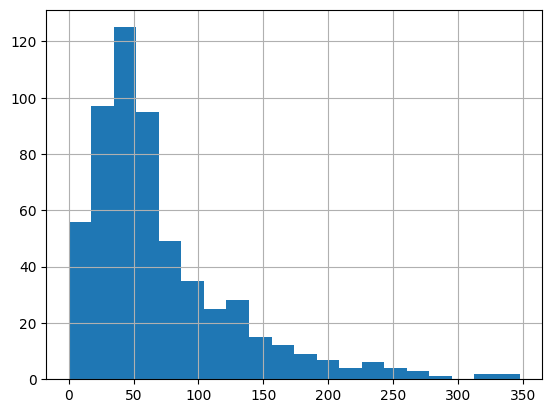

In [4]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [14]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 575


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
90,Powershell,Service Manager (services.msc)\nA GUI tool for...,31d581d8ea24442605e5c1c662d447b5,-119.268541,-54.108051,119.268541,541.080514,0.960694,10,0,0
91,Powershell,Install-Module\nInstalls PowerShell modules fr...,5df0ccb8a5096dd0d5e30b87a25f1345,-92.269738,-54.108051,119.268541,541.080514,0.960694,10,1,0
93,Powershell,/i (msiexec argument)\nIndicates installation ...,a1d240247e0beadefce88e5fb631725d,-47.365047,-54.108051,119.268541,541.080514,0.960694,10,2,0
211,Powershell,Set-Content\nWrites or replaces the content of...,1308516db1ce3834a2dde42ab99c3c5e,-46.281188,-54.108051,119.268541,541.080514,0.960694,10,3,0
92,Powershell,docker build\nCreates a Docker image from a Do...,a1e0e72839f32b6040e3ad3ef1c5c3e6,-45.441250,-54.108051,119.268541,541.080514,0.960694,10,4,0
94,Powershell,error during connect\nIndicates the Docker CLI...,fa14e849210808f8bf87d29005622d6d,-44.993797,-54.108051,119.268541,541.080514,0.960694,10,5,0
210,Powershell,az\nThe Azure CLI command-line tool for managi...,9376de9d5b22a60393b68271da0c480e,-43.612860,-54.108051,119.268541,541.080514,0.960694,10,6,0
212,Powershell,Get-Service\nDisplays the status of Windows se...,61dbfe3e3fd4becf9c271f621539b52a,-37.197970,-54.108051,119.268541,541.080514,0.960694,10,7,0
214,Powershell,-Force\nOverrides warnings or confirmation pro...,6d7a53df80e0774571798b7e4c583afe,-34.357676,-54.108051,119.268541,541.080514,0.960694,10,8,0
213,Powershell,NUL\nA virtual file in Windows that discards w...,eb95bc3e9d7175749fa85f045565d15f,-30.292446,-54.108051,119.268541,541.080514,0.960694,10,9,0



## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
90,Powershell,Service Manager (services.msc)\nA GUI tool for...,31d581d8ea24442605e5c1c662d447b5,-119.268541,-54.108051,119.268541,541.080514,0.960694,10,0,0
91,Powershell,Install-Module\nInstalls PowerShell modules fr...,5df0ccb8a5096dd0d5e30b87a25f1345,-92.269738,-54.108051,119.268541,541.080514,0.960694,10,1,0
93,Powershell,/i (msiexec argument)\nIndicates installation ...,a1d240247e0beadefce88e5fb631725d,-47.365047,-54.108051,119.268541,541.080514,0.960694,10,2,0
211,Powershell,Set-Content\nWrites or replaces the content of...,1308516db1ce3834a2dde42ab99c3c5e,-46.281188,-54.108051,119.268541,541.080514,0.960694,10,3,0
92,Powershell,docker build\nCreates a Docker image from a Do...,a1e0e72839f32b6040e3ad3ef1c5c3e6,-45.441250,-54.108051,119.268541,541.080514,0.960694,10,4,0
94,Powershell,error during connect\nIndicates the Docker CLI...,fa14e849210808f8bf87d29005622d6d,-44.993797,-54.108051,119.268541,541.080514,0.960694,10,5,0
210,Powershell,az\nThe Azure CLI command-line tool for managi...,9376de9d5b22a60393b68271da0c480e,-43.612860,-54.108051,119.268541,541.080514,0.960694,10,6,0
212,Powershell,Get-Service\nDisplays the status of Windows se...,61dbfe3e3fd4becf9c271f621539b52a,-37.197970,-54.108051,119.268541,541.080514,0.960694,10,7,0
214,Powershell,-Force\nOverrides warnings or confirmation pro...,6d7a53df80e0774571798b7e4c583afe,-34.357676,-54.108051,119.268541,541.080514,0.960694,10,8,0
213,Powershell,NUL\nA virtual file in Windows that discards w...,eb95bc3e9d7175749fa85f045565d15f,-30.292446,-54.108051,119.268541,541.080514,0.960694,10,9,0


In [18]:
existing_cards['age'].mean()

-70.93026202759748